# Wind-driven upwelling - 2 layer analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import NEMO_upwelling_postprocessing as ps
from matplotlib import colors
from cmocean import cm
from copy import copy
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

***

## Load and process results

The processing code can be found in `analysis-ben/modules/NEMO_upwelling_postprocessing.py` and the code development is documented in `analysis-ben/notebooks/SOG_upwelling_paperfigs/NEMO_postprocessing.ipynb`

Functions

In [28]:
def build_idealized_arrays(runs):
    """
    """
    
    # Initialize variables
    arrays = {}
    for key in ['g_prime', 'z_h', 'tau', 'N', 'ftW', 'z_u', 'x_u', 'j', 'slope']: arrays[key] = np.empty(0)
    ones = np.ones(sections['n'])
    
    # Wind integration factor
    jtau = (hour - 3) * 3600 * np.sin(np.arctan(2) - sections['angle'])

    # Loop through pycnocline depth and surface layer density
    ftW, z_u, x_u = np.empty(0), np.empty(0), np.empty(0)
    for z_h in param['z_h']:
        for rho_s in param['rho_s']:

            # Calculate reduced gravity and Rossby radius
            g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
            L_R = np.sqrt(g_prime * z_h) / const['f']

            # Loop through windspeed
            for U, tau in zip(param['u_wind'], param['tau']):

                # Concatenate scale parameters
                arrays['z_h'] = np.concatenate((arrays['z_h'], z_h * ones))
                arrays['tau'] = np.concatenate((arrays['tau'], tau * ones))
                arrays['g_prime'] = np.concatenate((arrays['g_prime'], g_prime * ones))
                
                # Calculate Wedderburn number predictor and observed upwelling/offshore advection
                arrays['N'] = np.concatenate((arrays['N'], np.array(runs[z_h][rho_s][U]['N_int'])))
                arrays['z_u'] = np.concatenate((arrays['z_u'], np.array(runs[z_h][rho_s][U]['z_u']) / z_h))
                arrays['x_u'] = np.concatenate((arrays['x_u'], np.array(runs[z_h][rho_s][U]['x_u']) / L_R))
                arrays['ftW'] = np.concatenate((
                    arrays['ftW'], tau * jtau / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h)),
                ))
                
                # Construct full j and slope arrays
                arrays['j'] = np.concatenate((arrays['j'], sections['ji'][0]))
                arrays['slope'] = np.concatenate((arrays['slope'], sections['slope']))
    
    # Calculate residuals
    x1, x2 = copy(arrays['ftW']), copy(arrays['ftW']) - 1
    x1[x1 > 1], x2[x2 < 0] = 1, 0
    arrays['z_u_res'] = arrays['z_u'] - x1
    arrays['x_u_res'] = arrays['x_u'] - x2
                
    return arrays


def build_hindcast_arrays(runs):
    """
    """

    # Calculate scale parameters
    z_h = runs.z_h.values.flatten()
    g_prime = const['g'] * (const['rho_0'] - runs.rho_s.values.flatten()) / const['rho_0']
    L_R = np.sqrt(g_prime * z_h) / const['f']
    
    # Initialize dict
    arrays = {'g_prime': g_prime, 'z_h': z_h, 'j': np.empty(0), 'slope': np.empty(0)}
    
    # Calculate Wedderburn number predictor and observed upwelling/offshore advection
    arrays['tau'] = runs_hindcast.tau.values.flatten() / 86400
    arrays['N'] = runs.N_int.values.flatten()
    arrays['z_u'] = runs.z_u.values.flatten() / z_h
    arrays['x_u'] = runs.x_u.values.flatten() / L_R
    arrays['ftW'] = runs.tau.values.flatten() / (const['rho_0'] * z_h * np.sqrt(g_prime * z_h))
    
    # Construct full j and slope arrays
    for n in range(int(len(z_h) / sections['n'])):
        arrays['j'] = np.concatenate((arrays['j'], sections['ji'][0]))
        arrays['slope'] = np.concatenate((arrays['slope'], sections['slope']))
    
    # Calculate residuals
    x1, x2 = copy(arrays['ftW']), copy(arrays['ftW']) - 1
    x1[x1 > 1], x2[x2 < 0] = 1, 0
    arrays['z_u_res'] = arrays['z_u'] - x1
    arrays['x_u_res'] = arrays['x_u'] - x2
    
    return arrays

Load netCDF files and define global parameters

In [4]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: grids, _, events_northerly, events_southerly = yaml.safe_load_all(f)

# Load netCDF results and geo files
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Global parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, L = 24, 440, 50

# Calculate coastline indices
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry)
sections = ps.calc_coastline_indices_HRDPS(sections, mask, grid_HRDPS)

# Process idealized 2-layer results
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
}
#runs_idealized = ps.process_idealized_results(param, sections, mask, grids, keys=['z_h', 'rho_s', 'u_wind'])

# Process hindcast results (or load from netCDF)
#runs = ps.process_hindcast_results(events_southerly, sections, mask, HRDPS)
runs_hindcast = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/notebooks/SOG_upwelling_paperfigs/hindcast_processed.nc')

# Concatenate arrays for plotting
#arrays = {
#    'idealized': build_idealized_arrays(runs_idealized),
#    'hindcast': build_hindcast_arrays(runs_hindcast),
#}

In [5]:
runs_idealized = ps.process_idealized_results(param, sections, mask, grids['ideal'], keys=['z_h', 'rho_s', 'u_wind'])

In [29]:
arrays = {
    'idealized': build_idealized_arrays(runs_idealized),
    'hindcast': build_hindcast_arrays(runs_hindcast),
}

***

## Plot results

Plotting functions

In [11]:
def plot_bathymetry(fig, ax, bathy, tmask):
    """
    """
    
    # Plot landmask and bathymetry
    c = ax.contourf(bathy, cmap='YlGnBu', levels=np.arange(0, 451, 50), extend='max')
    ax.contour(bathy, levels=[200], colors='w')
    ax.contourf(tmask[0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(tmask[0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([110, 350])
    viz_tools.set_aspect(ax)
    
    return c


def plot_contour(fig, ax, key, arrays, label, std=1, cmap='coolwarm'):
    """Stdev = 1 corresponds to 2.5 km and 0.1 of ft/W (or ~2.5 hours at constant W)
    """
    
    # Interpolate upwelling variable to grid
    xi, yi = np.meshgrid(np.arange(0, 4, 0.1), sections['ji'][0])
    data = gaussian_filter(griddata((arrays['ftW'], arrays['j']), arrays[key], (xi, yi), method='nearest'), std)
    
    # Plot interpolated field and original datapoint locations
    c = ax.contourf(xi, yi, data, levels=np.arange(-2.5, 2.6, 0.2), cmap=cmap, extend='both')
    ax.plot(arrays['ftW'], arrays['j'], 'ko', markersize=2)
    ax.set_xlim([0, 3.5])
    
    return c


def plot_basic(color='k'):
    """
    """
    
    # Make figure panels
    fig, axs = plt.subplots(2, 2, figsize=(15, 12), gridspec_kw={'hspace': 0.1})

    # Loop through models
    k = 0
    for ax_row, model in zip(axs, arrays):

        # Make plots
        lines = [([0, 1, 4], [0, 1, 1]), ([0, 1, 4], [0, 0, 3])]
        for ax, yvar, line, ylabel in zip(ax_row, ['z_u', 'x_u'], lines, ['$z_u/z_h$', '$x_u/L_R$']):
            ax.plot(arrays[model]['ftW'], arrays[model][yvar], 'o', color=color, label='model')
            ax.plot(*line, '--', color='magenta', label='predicted', zorder=10)
            ax.text(0.02, 0.95, f'({chr(97+k)})', transform=ax.transAxes)
            ax.text(0.85, 0.02, model.capitalize(), transform=ax.transAxes)
            ax.set_xlim([0, 3.5])
            ax.set_ylim([0, 4])
            ax.set_ylabel(ylabel)
            if model is 'idealized': ax.xaxis.set_ticklabels('')
            else: ax.set_xlabel('$ft/W$')
            k += 1

    # Show legend
    axs[0, 0].legend(loc=1)
    
    return fig, axs


def plot_topographic():
    """
    """

    # Make basic plot and return handles
    fig, axs = plot_basic(color='lightgray')

    # Loop through models
    for ax_row, model, threshold in zip(axs, arrays, [(3, 10), (2, 10)]):

        # Calculate Burger number from integrated Brunt Vaisala frequency
        S = arrays[model]['slope'] * arrays[model]['N'] / const['f'] / const['H']

        # Limit j extent of analysis
        index = (arrays[model]['j'] > 400) & (arrays[model]['j'] < 700)

        # Plot results at low and high Burger number
        for ax, yvar in zip(ax_row, ['z_u', 'x_u']):
            for iS, color, label in zip([S < threshold[0], S > threshold[1]], ['skyblue', 'gold'], ['$S<2$', '$S>10$']):
                ax.plot(
                    arrays[model]['ftW'][iS & index], arrays[model][yvar][iS & index],
                    'ko', markerfacecolor=color, label=label,
            )

    # Show legend
    axs[0, 0].legend(loc=1)
    
    return fig, ax


def plot_spatial():
    """
    """
    
    # Make plots and format
    gridspec_kw = {'width_ratios': [2, 2, 0.5, 1.5], 'wspace': 0.1, 'hspace': 0.1}
    text_props = {'facecolor': 'w', 'edgecolor': 'w'}
    fig, axs = plt.subplots(2, 4, figsize=(15, 12), gridspec_kw=gridspec_kw)
    
    # Loop through models
    k = 0
    for row, model in zip(axs, arrays):

        # Interpolate to contour grid and plot results
        labels = ['$z_u/z_h$ residual', '$x_u/L_R$ residual']
        for ax, key, cmap, label, xbar in zip(row[:2], ['z_u', 'x_u'], [cm.curl, cm.delta], labels, [0.145, 0.405]):
            c = plot_contour(fig, ax, key+'_res', arrays[model], label, cmap=cmap)
            ax.text(0.77, 0.03, model.capitalize(), transform=ax.transAxes, bbox=text_props)
            if model is 'hindcast':
                cax = fig.add_axes([xbar, 0.05, 0.2, 0.01])
                fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=range(-3, 4))
        
        # Plot bottom slope and coastline reference
        row[2].plot(sections['slope'], sections['ji'][0], 'k-')
        row[2].set_xlim([0, 0.1])
        c = plot_bathymetry(fig, row[3], bathy.Bathymetry, mask.tmask[0, ...])
            
        # Formatting
        xlabels = ['$ft/W$', '$ft/W$', 'Bottom slope', 'Grid X']
        for ax, col, xlabel, xpos in zip(row, range(4), xlabels, [0.02, 0.02, 0.1, 0.03]):
            ax.set_ylim([365, 715])
            ax.text(xpos, 0.95, f'({chr(97+k)})', transform=ax.transAxes, bbox=text_props)
            if col > 0: ax.yaxis.set_ticklabels('')
            else: ax.set_ylabel('Grid Y')
            if model is 'hindcast':
                ax.set_xlabel(xlabel)
                cax = fig.add_axes([0.73, 0.05, 0.17, 0.01])
                fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]', ticks=range(0, 450, 100))
            else: ax.xaxis.set_ticklabels('')
            k += 1

    return fig, axs


def plot_residuals():
    """
    """
    
    # Make figure panels
    text_props = {'facecolor': 'w', 'edgecolor': 'w'}
    fig, axs = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'wspace': 0.1})

    # Loop through models
    for k, ax, model in zip(range(2), axs, arrays):

        # Make plots
        offset = 1 if model is 'hindcast' else 0
        index = arrays[model]['ftW'] > 1
        ax.plot(arrays[model]['z_u_res'][index], arrays[model]['x_u_res'][index], 'ko', label='Model')
        ax.plot([-0.5, 3], [-1, 6], '--', color='magenta', label='Modes of variability (illustrative)')
        ax.plot([-0.5, 3], [2+offset, -1+offset], '--', color='magenta')
        ax.text(0.02, 0.95, f'({chr(97+k)})', transform=ax.transAxes)
        ax.text(0.85, 0.02, model.capitalize(), transform=ax.transAxes, bbox=text_props)
        ax.set_xlim([-0.5, 3])
        ax.set_ylim([-1, 4])
        ax.set_xlabel('$z_u/z_h$ residual')
        if model is 'idealized': ax.set_ylabel('$x_u/L_R$ residual')
        else: ax.yaxis.set_ticklabels('')

    # Show legend
    axs[0].legend(loc=1, framealpha=1)
    
    return fig, axs

***

### Basic plot

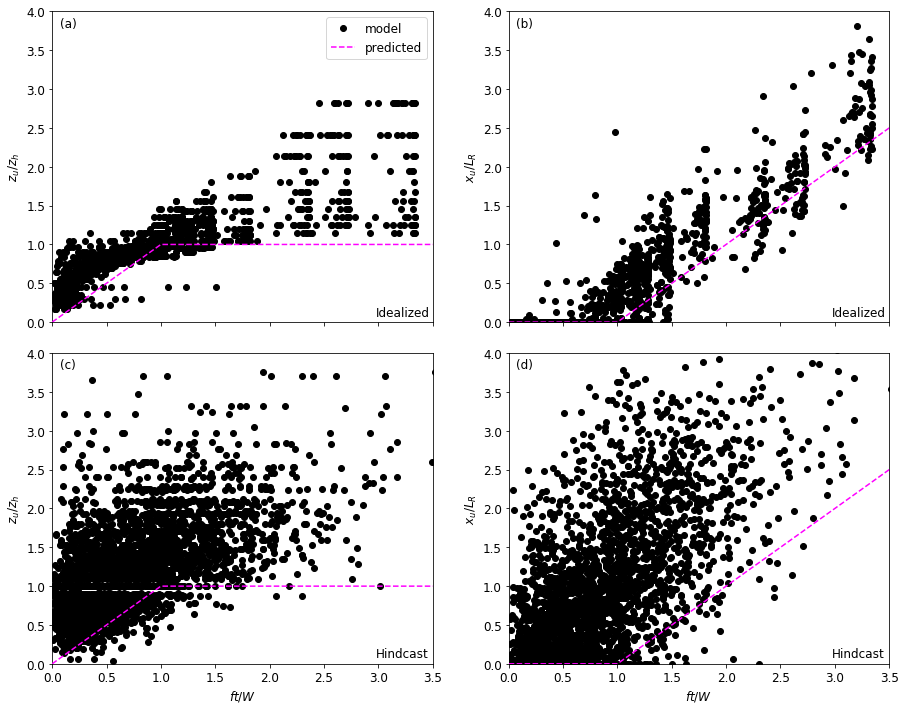

In [8]:
fig, axs = plot_basic()

***

### Spatial dependence

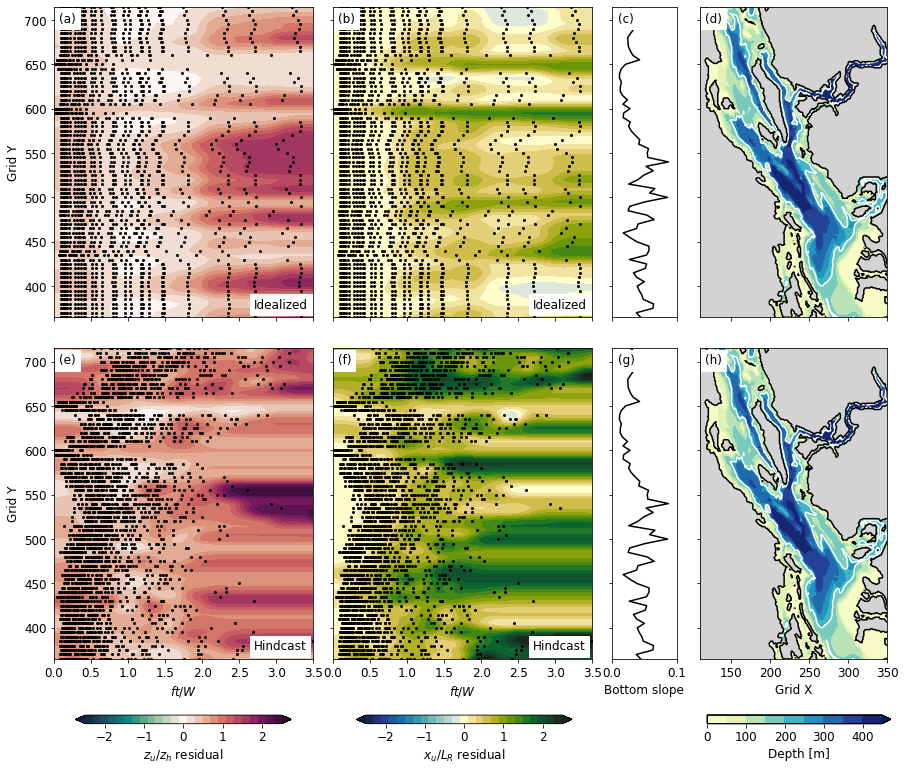

In [9]:
fig, axs = plot_spatial()

***

### Residuals

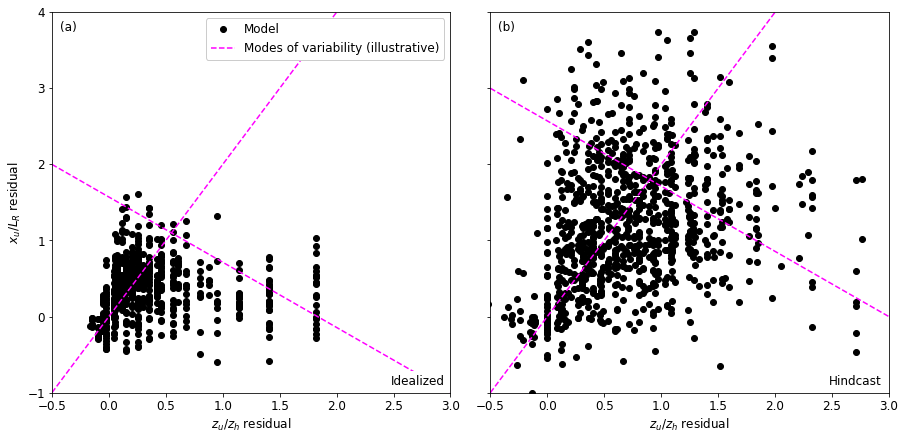

In [12]:
fig, axs = plot_residuals()

***

### Topographic dependence

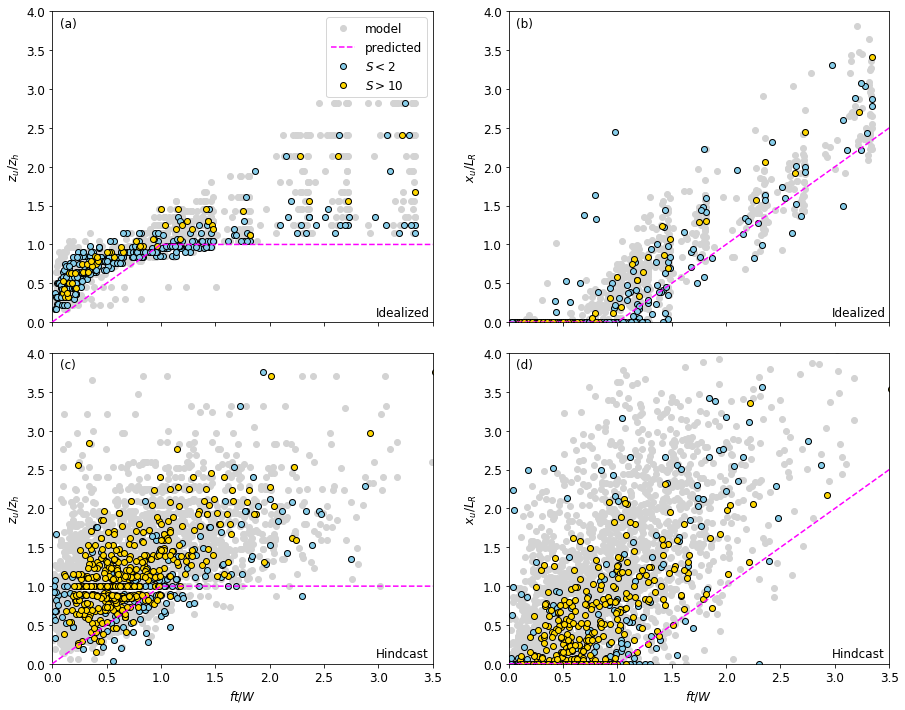

In [13]:
fig, ax = plot_topographic()

***

### Choboter et al. 2011

$$\boxed{\hspace{0.5cm}\frac{Z}{H} = -\frac{1}{2\tan^{-1}(S)}\cos^{-1}\left\{1 - \frac{2S^2}{1 + S^2}\left(1 - e^{-2\tan^{-1}(S)\frac{ft}{W}}\right)\right\}\hspace{0.5cm}}$$

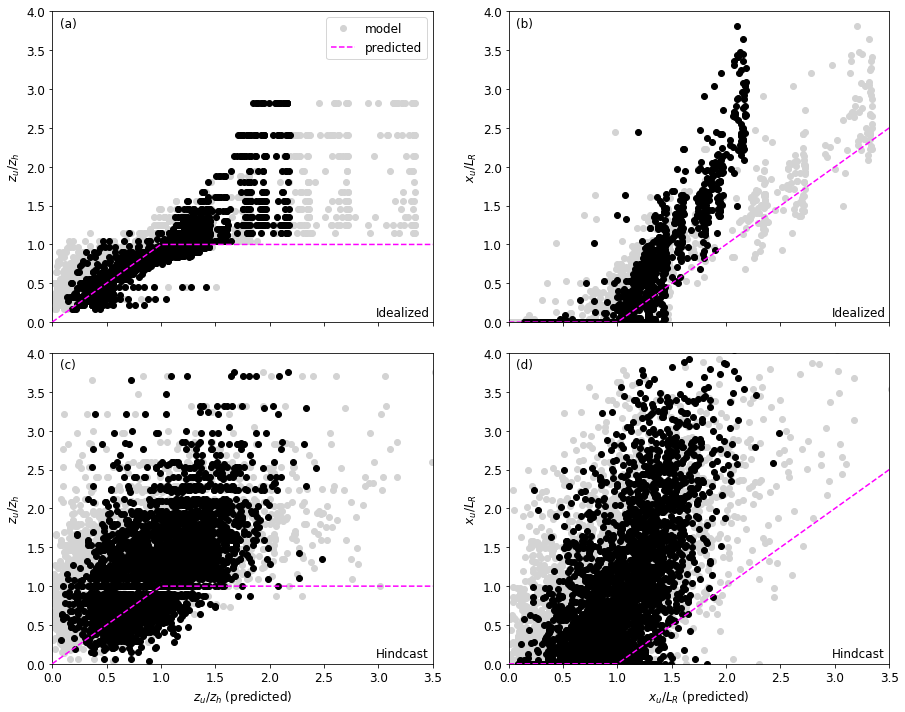

In [44]:
# Make basic plot and return handles
fig, axs = plot_basic(color='lightgray')

for ax_row, model, threshold in zip(axs, arrays, [(3, 10), (2, 10)]):

    # Calculate Burger number from integrated Brunt Vaisala frequency
    S = arrays[model]['slope'] * arrays[model]['N'] / const['f'] / const['H']
    
    exp = 1 - np.exp(-2 * np.arctan(S) * arrays[model]['ftW'] * arrays[model]['z_h']**2 / const['H']**2)
    Z = np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S)) * const['H'] / arrays[model]['z_h']

    # Plot results at low and high Burger number
    for ax, yvar, xlabel in zip(ax_row, ['z_u', 'x_u'], ['$z_u/z_h$', '$x_u/L_R$']):
        ax.plot(Z, arrays[model][yvar], 'ko')
        if model is 'hindcast':
            ax.set_xlabel(f'{xlabel} (predicted)')

# Show legend
axs[0, 0].legend(loc=1)

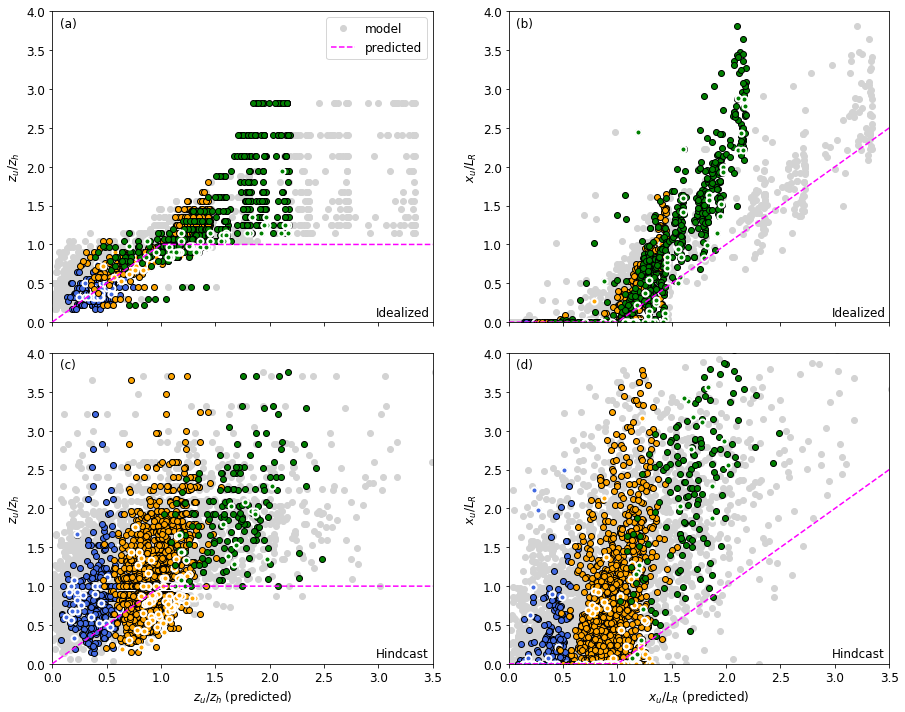

In [56]:
# Make basic plot and return handles
fig, axs = plot_basic(color='lightgray')

# Loop through models
limits = [
    [(0, 0.1), (0.1, 0.2), (0.2, 0.3)],
    [(0, 0.01), (0.02, 0.05), (0.1, 0.2)],
]
for ax_row, model, threshold, lims in zip(axs, arrays, [(3, 10), (2, 10)], limits):

    # Calculate Burger number from integrated Brunt Vaisala frequency
    S = arrays[model]['slope'] * arrays[model]['N'] / const['f'] / const['H']
    
    exp = 1 - np.exp(-2 * np.arctan(S) * arrays[model]['ftW'] * arrays[model]['z_h']**2 / const['H']**2)
    Z = np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S)) * const['H'] / arrays[model]['z_h']
    cut = S < 2

    # Plot results at low and high Burger number
    for ax, yvar, xlabel in zip(ax_row, ['z_u', 'x_u'], ['$z_u/z_h$', '$x_u/L_R$']):
        for lim, color in zip(lims, ['royalblue', 'orange', 'g']):
            index = (arrays[model]['tau'] > lim[0]) & (arrays[model]['tau'] < lim[1])
            ax.plot(Z[index], arrays[model][yvar][index], 'ko', markerfacecolor=color)
            ax.plot(Z[index & cut], arrays[model][yvar][index & cut], 'wo', markerfacecolor=color, markeredgewidth=2)
        if model is 'hindcast':
            ax.set_xlabel(f'{xlabel} (predicted)')

# Show legend
axs[0, 0].legend(loc=1)